In [87]:
import seaborn as sns
import matplotlib.pyplot as plt
#criando uma pleta de cores
minha_paleta = ['royalblue','skyblue','lightsteelblue', 'cornflowerblue']
sns.set_palette(minha_paleta)
import pandas as pd
from sklearn.metrics import r2_score
import statsmodels.api as sm
from sklearn.cluster import KMeans
from statsmodels.stats.diagnostic import het_white
from scipy.stats import shapiro
import plotly.graph_objs as go
import random
from sklearn.model_selection import train_test_split

#Entendimento dos dados

##Coleta e descrição dos dados

In [2]:
#Importando
df = pd.read_excel('/content/base_plano_de_saude.xlsx', sheet_name='base')

In [3]:
#Verificando a estrutura
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Idade        1338 non-null   int64  
 1   Sexo         1338 non-null   object 
 2   IMC          1338 non-null   float64
 3   Qte_Filhos   1338 non-null   int64  
 4   Fumante      1338 non-null   object 
 5   Região       1338 non-null   object 
 6   Custo_Saude  1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [4]:
#Analisando as primeiras linhas
df.head()

,Idade,Sexo,IMC,Qte_Filhos,Fumante,Região,Custo_Saude
0,19,Feminino,27.900,0,Sim,Centro,1688.492400
1,18,Masculino,33.770,1,Não,Sudeste,172.555230
2,28,Masculino,33.000,3,Não,Sudeste,444.946200
3,33,Masculino,22.705,0,Não,Norte,2198.447061
4,32,Masculino,28.880,0,Não,Norte,386.685520


In [5]:
#Verificação de registros duplicados
df[df.duplicated(keep=False)]

,Idade,Sexo,IMC,Qte_Filhos,Fumante,Região,Custo_Saude
195,19,Masculino,30.59,0,Não,Norte,163.95631
581,19,Masculino,30.59,0,Não,Norte,163.95631


In [6]:
#Verificação de valores inconsistentes(variáveis quantitativas)
df.describe()

,Idade,IMC,Qte_Filhos,Custo_Saude
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,1327.042227
std,14.049960,6.098187,1.205493,1211.001124
min,18.000000,15.960000,0.000000,112.187390
25%,27.000000,26.296250,0.000000,474.028715
50%,39.000000,30.400000,1.000000,938.203300
75%,51.000000,34.693750,2.000000,1663.991252
max,64.000000,53.130000,5.000000,6377.042801


In [7]:
#Verificação de valores inconsistentes(variáveis qualitativas)
df['Sexo'].value_counts(),df['Fumante'].value_counts(), df['Região'].value_counts()

(Masculino    676
 Feminino     662
 Name: Sexo, dtype: int64,
 Não    1064
 Sim     274
 Name: Fumante, dtype: int64,
 Sudeste     364
 Centro      325
 Norte       325
 Nordeste    324
 Name: Região, dtype: int64)

In [8]:
#Criando um dicionário de dados
df_meta_dados = pd.DataFrame({'Variavel': df.columns.tolist(),
                                 'Descricao': ['Idade do colaborador','Sexo do colaborador',
                                               'Índice de Massa Corporal do colaborador',
                                               'Qte de filhos que o colaborador possui',
                                               'Flag se o colaborador é fumante ou não fumante',
                                               'Região do Brasil onde o colaborador mora',
                                               'Custo de Plano de Saúde com esse colaborador']})

##Análise exploratória

###Análise univaridada

In [9]:
#Criando uma função para gerar as tabelas de frequência(variáveis qualitativas)
def tabela_frequencia(coluna):
  tabela = coluna.value_counts().reset_index() #Transformando a contagem de valores em um dataframe
  nome_coluna = tabela.columns[1] #Obtendo o nome da coluna
  tabela = tabela.rename(columns={nome_coluna: 'frequencia_absoluta'}) #Ajustando os nomes das colunas
  tabela = tabela.rename(columns={'index': nome_coluna})
  tabela['frequencia_relativa'] = tabela['frequencia_absoluta']/tabela['frequencia_absoluta'].sum()
  tabela['frequencia_acumulada'] = tabela['frequencia_relativa'].cumsum()
  return tabela

####Custo_Saude

In [10]:
#Analisando as medidas estatísticas
print(f'''Medidas estatísticas

{df['Custo_Saude'].describe()}
----------------------------------
nulos/ausentes

{len(df)-df['Custo_Saude'].count()}''')

Medidas estatísticas

count    1338.000000
mean     1327.042227
std      1211.001124
min       112.187390
25%       474.028715
50%       938.203300
75%      1663.991252
max      6377.042801
Name: Custo_Saude, dtype: float64
----------------------------------
nulos/ausentes

0


In [11]:
#Total
df['Custo_Saude'].sum()

1775582.4990758998

<ipython-input-12-ed436cd81037>:4: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=df, x='Custo_Saude', bins=12, palette=minha_paleta, kde=False, ax=axes[0])


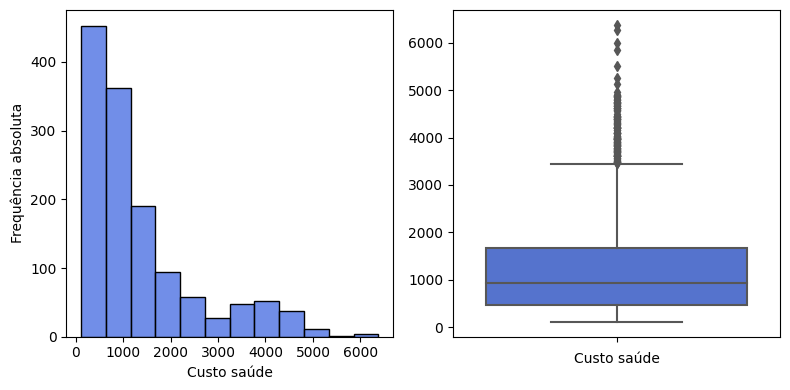

In [12]:
#Plotando o histograma e o boxplot
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

sns.histplot(data=df, x='Custo_Saude', bins=12, palette=minha_paleta, kde=False, ax=axes[0])
axes[0].set_ylabel('Frequência absoluta')
axes[0].set_xlabel('Custo saúde')

sns.boxplot(data=df, y='Custo_Saude', palette=minha_paleta, ax=axes[1])
axes[1].set_xlabel('Custo saúde')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()

####Idade

In [13]:
#Analisando as medidas estatísticas
print(f'''Medidas estatísticas

{df['Idade'].describe()}
----------------------------------
nulos/ausentes

{len(df)-df['Idade'].count()}''')

Medidas estatísticas

count    1338.000000
mean       39.207025
std        14.049960
min        18.000000
25%        27.000000
50%        39.000000
75%        51.000000
max        64.000000
Name: Idade, dtype: float64
----------------------------------
nulos/ausentes

0


<ipython-input-14-5fb25fbc1660>:4: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=df, x='Idade', bins=12, palette=minha_paleta, kde=False, ax=axes[0])


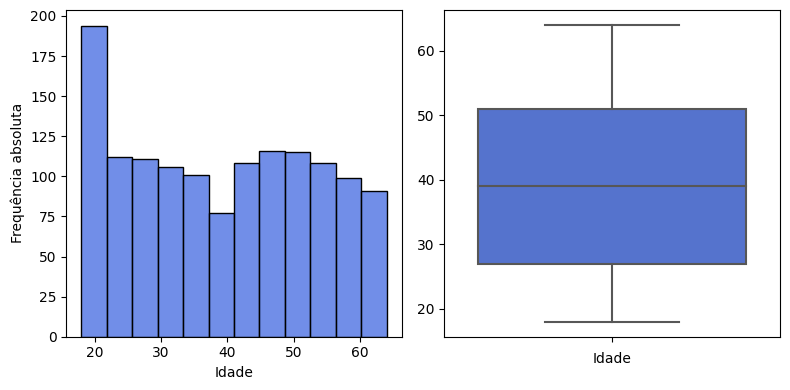

In [14]:
#Plotando o histograma e o boxplot
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

sns.histplot(data=df, x='Idade', bins=12, palette=minha_paleta, kde=False, ax=axes[0])
axes[0].set_ylabel('Frequência absoluta')
axes[0].set_xlabel('Idade')

sns.boxplot(data=df, y='Idade', palette=minha_paleta, ax=axes[1])
axes[1].set_xlabel('Idade')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()

####Sexo

In [15]:
#Analisando as medidas estatísticas
print(f'''Medidas estatísticas

{df['Sexo'].describe()}
----------------------------------
nulos/ausentes

{len(df)-df['Sexo'].count()}''')

Medidas estatísticas

count          1338
unique            2
top       Masculino
freq            676
Name: Sexo, dtype: object
----------------------------------
nulos/ausentes

0


In [16]:
tabela_frequencia(df['Sexo'])

,Sexo,frequencia_absoluta,frequencia_relativa,frequencia_acumulada
0,Masculino,676,0.505232,0.505232
1,Feminino,662,0.494768,1.000000


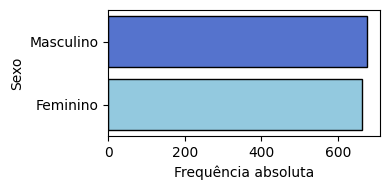

In [17]:
#Plotando gráficos de barra
contagem_sexo = df['Sexo'].value_counts()
plt.figure(figsize=(4, 2))
sns.barplot(x=contagem_sexo.values, y=contagem_sexo.index, palette=minha_paleta, edgecolor='black')
plt.xlabel('Frequência absoluta')
plt.ylabel('Sexo')
plt.tight_layout()
plt.show()

####Qte_Filhos

In [18]:
#Analisando as medidas estatísticas
#Utilizei o astype(str) para transformar momentâneamente em string, tendo em vista que
#por se tratar de uma variável quantitativa discreta, essa transformação facilita a análise
print(f'''Medidas estatísticas

{df['Qte_Filhos'].astype(str).describe()}
----------------------------------
nulos/ausentes

{len(df)-df['Qte_Filhos'].astype(str).count()}''')

Medidas estatísticas

count     1338
unique       6
top          0
freq       574
Name: Qte_Filhos, dtype: object
----------------------------------
nulos/ausentes

0


In [19]:
tabela_frequencia(df['Qte_Filhos'].astype(str))

,Qte_Filhos,frequencia_absoluta,frequencia_relativa,frequencia_acumulada
0,0,574,0.428999,0.428999
1,1,324,0.242152,0.671151
2,2,240,0.179372,0.850523
3,3,157,0.117339,0.967862
4,4,25,0.018685,0.986547
5,5,18,0.013453,1.000000


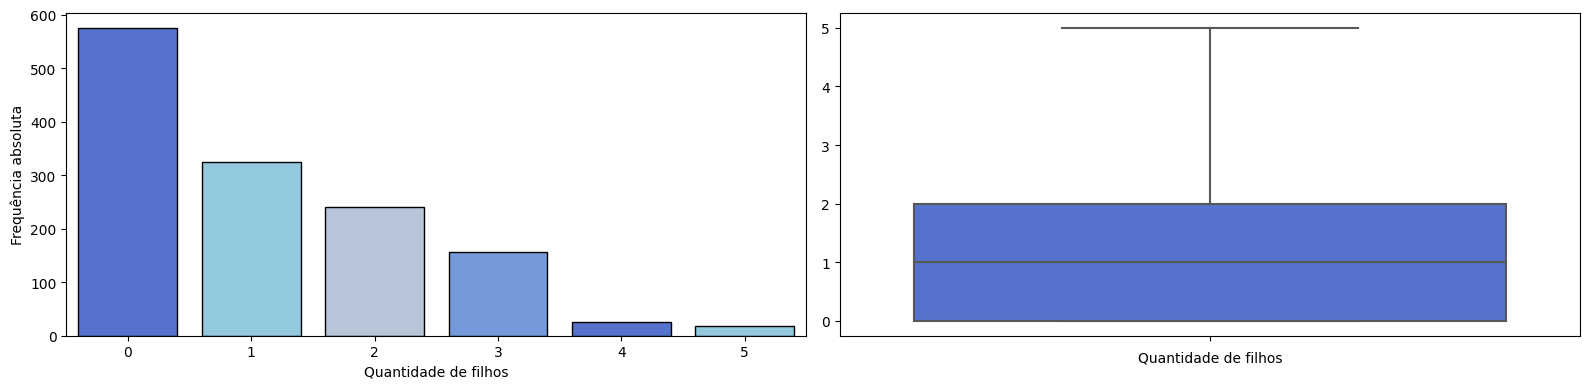

In [20]:
#Plotando o gráfico de barras e o boxplot
fig, axes = plt.subplots(1, 2, figsize=(16, 4))

sns.countplot(data=df, x='Qte_Filhos', palette=minha_paleta, ax=axes[0], edgecolor='black')
axes[0].set_xlabel('Quantidade de filhos')
axes[0].set_ylabel('Frequência absoluta')

sns.boxplot(data=df, y='Qte_Filhos', palette=minha_paleta, ax=axes[1])
axes[1].set_ylabel('')
axes[1].set_xlabel('Quantidade de filhos')

plt.tight_layout()
plt.show()

####IMC

In [21]:
#Analisando as medidas estatísticas
print(f'''Medidas estatísticas

{df['IMC'].describe()}
----------------------------------
nulos/ausentes

{len(df)-df['IMC'].count()}''')

Medidas estatísticas

count    1338.000000
mean       30.663397
std         6.098187
min        15.960000
25%        26.296250
50%        30.400000
75%        34.693750
max        53.130000
Name: IMC, dtype: float64
----------------------------------
nulos/ausentes

0


<ipython-input-22-3d138cd5e288>:4: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=df, x='IMC', bins=12, palette=minha_paleta, kde=False, ax=axes[0])


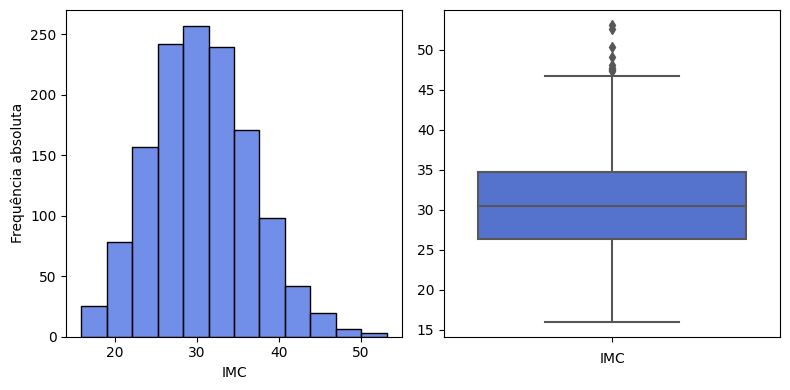

In [22]:
#Plotando o histograma e o boxplot
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

sns.histplot(data=df, x='IMC', bins=12, palette=minha_paleta, kde=False, ax=axes[0])
axes[0].set_ylabel('Frequência absoluta')
axes[0].set_xlabel('IMC')

sns.boxplot(data=df, y='IMC', palette=minha_paleta, ax=axes[1])
axes[1].set_xlabel('IMC')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()

In [23]:
#Criando faixas de IMC
df['Faixas_IMC'] = ''
for cont in range(0,len(df)):
  if df['IMC'][cont] < 17:
    df['Faixas_IMC'][cont] = 'muito abaixo do peso'
  elif df['IMC'][cont] >= 17 and df['IMC'][cont] <= 18.49:
    df['Faixas_IMC'][cont] = 'abaixo do peso'
  elif df['IMC'][cont] >= 18.50 and df['IMC'][cont] <= 24.99:
    df['Faixas_IMC'][cont] = 'peso normal'
  elif df['IMC'][cont] >= 25 and df['IMC'][cont] <= 29.99:
    df['Faixas_IMC'][cont] = 'acima do peso'
  elif df['IMC'][cont] >= 30 and df['IMC'][cont] <= 34.99:
    df['Faixas_IMC'][cont] = 'obesidade'
  elif df['IMC'][cont] >= 35 and df['IMC'][cont] <= 39.995:
    df['Faixas_IMC'][cont] = 'obesidade severa'
  elif df['IMC'][cont] >= 40:
    df['Faixas_IMC'][cont] = 'obesidade mórbida'

<ipython-input-23-724a4a9d8b0d>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Faixas_IMC'][cont] = 'acima do peso'
<ipython-input-23-724a4a9d8b0d>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Faixas_IMC'][cont] = 'obesidade'
<ipython-input-23-724a4a9d8b0d>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Faixas_IMC'][cont] = 'peso normal'
<ipython-input-23-724a4a9d8b0d>:15: SettingWithCopyWarning: 
A value is tryin

In [24]:
tabela_frequencia(df['Faixas_IMC'])

,Faixas_IMC,frequencia_absoluta,frequencia_relativa,frequencia_acumulada
0,obesidade,391,0.292227,0.292227
1,acima do peso,386,0.288490,0.580717
2,peso normal,225,0.168161,0.748879
3,obesidade severa,225,0.168161,0.917040
4,obesidade mórbida,91,0.068012,0.985052
5,abaixo do peso,17,0.012706,0.997758
6,muito abaixo do peso,3,0.002242,1.000000


####Fumante

In [25]:
#Analisando as medidas estatísticas
print(f'''Medidas estatísticas

{df['Fumante'].describe()}
----------------------------------
nulos/ausentes

{len(df)-df['Fumante'].count()}''')

Medidas estatísticas

count     1338
unique       2
top        Não
freq      1064
Name: Fumante, dtype: object
----------------------------------
nulos/ausentes

0


In [26]:
tabela_frequencia(df['Fumante'])

,Fumante,frequencia_absoluta,frequencia_relativa,frequencia_acumulada
0,Não,1064,0.795217,0.795217
1,Sim,274,0.204783,1.000000


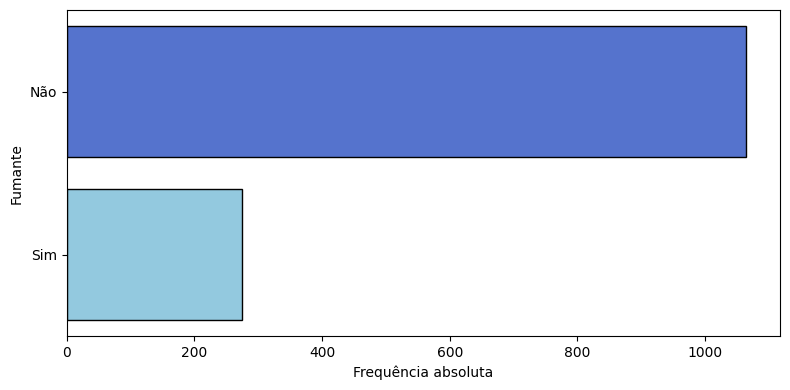

In [27]:
#Plotando gráfico de barra
contagem_sexo = df['Fumante'].value_counts()
plt.figure(figsize=(8, 4))
sns.barplot(x=contagem_sexo.values, y=contagem_sexo.index, palette=minha_paleta, edgecolor='black')
plt.xlabel('Frequência absoluta')
plt.ylabel('Fumante')
plt.tight_layout()
plt.show()

<ipython-input-28-e6e5c7cdd12d>:4: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=df, x='IMC', bins=12, palette=minha_paleta, ax=axes[0])


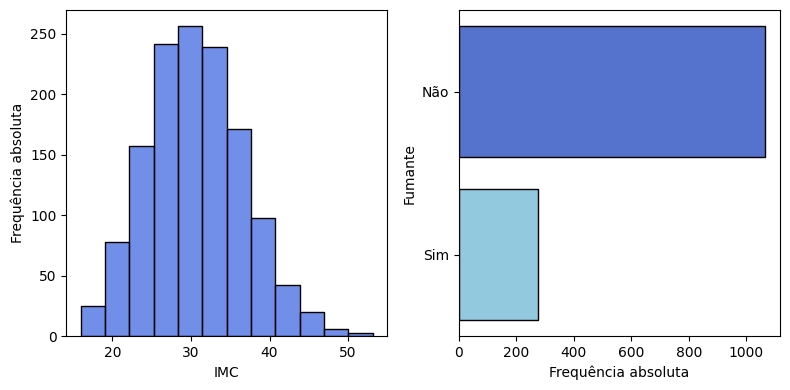

In [28]:
#Plotando os gráficos das variáveis Fumante e IMC
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

sns.histplot(data=df, x='IMC', bins=12, palette=minha_paleta, ax=axes[0])
axes[0].set_ylabel('Frequência absoluta')
axes[0].set_xlabel('IMC')

contagem_fumante = df['Fumante'].value_counts()
sns.barplot(data=df, y=contagem_fumante.index, x=contagem_fumante.values, palette=minha_paleta, edgecolor='black', ax=axes[1])
axes[1].set_xlabel('Frequência absoluta')
axes[1].set_ylabel('Fumante')

plt.tight_layout()
plt.show()

####Região

In [29]:
#Analisando as medidas estatísticas
print(f'''Medidas estatísticas

{df['Região'].describe()}
----------------------------------
nulos/ausentes

{len(df)-df['Região'].count()}''')

Medidas estatísticas

count        1338
unique          4
top       Sudeste
freq          364
Name: Região, dtype: object
----------------------------------
nulos/ausentes

0


In [30]:
tabela_frequencia(df['Região'])

,Região,frequencia_absoluta,frequencia_relativa,frequencia_acumulada
0,Sudeste,364,0.272048,0.272048
1,Centro,325,0.242900,0.514948
2,Norte,325,0.242900,0.757848
3,Nordeste,324,0.242152,1.000000


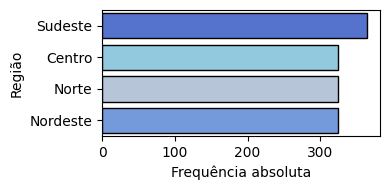

In [31]:
#Plotando gráfico de barra
contagem_sexo = df['Região'].value_counts()
plt.figure(figsize=(4, 2))
sns.barplot(x=contagem_sexo.values, y=contagem_sexo.index, palette=minha_paleta, edgecolor='black')
plt.xlabel('Frequência absoluta')
plt.ylabel('Região')
plt.tight_layout()
plt.show()

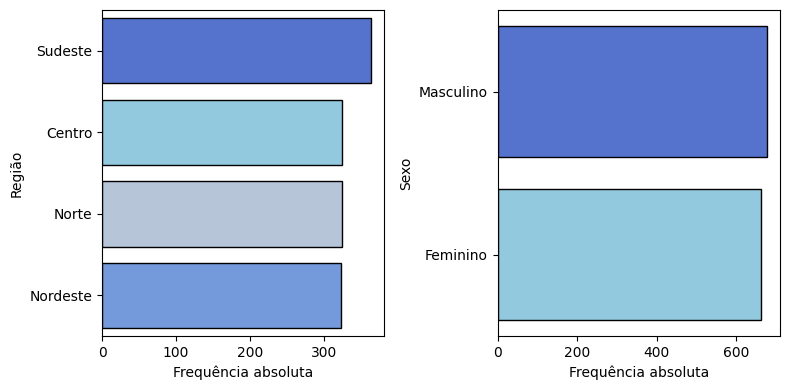

In [32]:
#Plotando Região e Sexo
contagem_regiao = df['Região'].value_counts()
contagem_sexo = df['Sexo'].value_counts()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

sns.barplot(x=contagem_regiao.values, y=contagem_regiao.index, ax=ax1, palette=minha_paleta, edgecolor='black')
ax1.set_xlabel('Frequência absoluta')
ax1.set_ylabel('Região')

sns.barplot(x=contagem_sexo.values, y=contagem_sexo.index, ax=ax2, palette=minha_paleta, edgecolor='black')
ax2.set_xlabel('Frequência absoluta')
ax2.set_ylabel('Sexo')

plt.tight_layout()
plt.show()

###Análise bivariada

In [33]:
#Exibindo a estrutura
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Idade        1338 non-null   int64  
 1   Sexo         1338 non-null   object 
 2   IMC          1338 non-null   float64
 3   Qte_Filhos   1338 non-null   int64  
 4   Fumante      1338 non-null   object 
 5   Região       1338 non-null   object 
 6   Custo_Saude  1338 non-null   float64
 7   Faixas_IMC   1338 non-null   object 
dtypes: float64(2), int64(2), object(4)
memory usage: 83.8+ KB


####Custo_Saude X Fumante

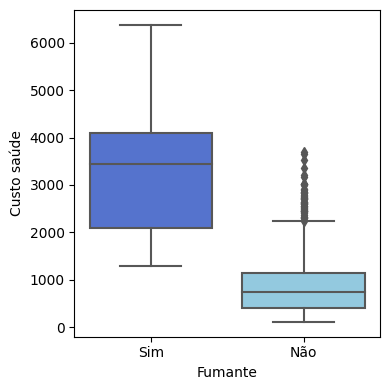

In [34]:
plt.figure(figsize=(4, 4))
sns.boxplot(x='Fumante', y='Custo_Saude', data=df, palette=minha_paleta)
plt.xlabel('Fumante')
plt.ylabel('Custo saúde')
plt.tight_layout()
plt.show()

In [35]:
variavel_dummie = pd.get_dummies(df['Fumante'], drop_first=True) #É preciso transformar a variável qualitativa em dummie
variavel_dummie = sm.add_constant(variavel_dummie)
modelo = sm.OLS(df['Custo_Saude'], variavel_dummie).fit() #Cria um modelo de regressão linear simples
r_squared = modelo.rsquared #Extrai o R²
print(f"O coeficiente de determinação (R²) é: {r_squared}")

O coeficiente de determinação (R²) é: 0.6197648148218988


####Custo_Saude X Sexo

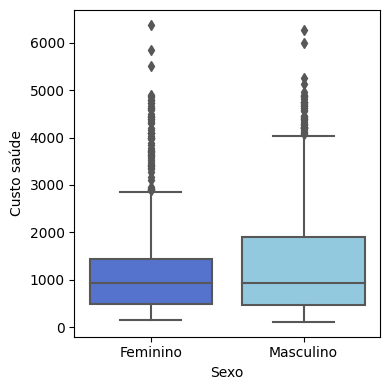

In [36]:
plt.figure(figsize=(4, 4))
sns.boxplot(x='Sexo', y='Custo_Saude', data=df, palette=minha_paleta)
plt.xlabel('Sexo')
plt.ylabel('Custo saúde')
plt.tight_layout()
plt.show()

In [37]:
variavel_dummie = pd.get_dummies(df['Sexo'], drop_first=True) #É preciso transformar a variável qualitativa em dummie
variavel_dummie = sm.add_constant(variavel_dummie)
modelo = sm.OLS(df['Custo_Saude'], variavel_dummie).fit() #Cria um modelo de regressão linear simples
r_squared = modelo.rsquared #Extrai o R²
print(f"O coeficiente de determinação (R²) é: {r_squared}")

O coeficiente de determinação (R²) é: 0.0032823803913607508


####Custo_Saude X Região

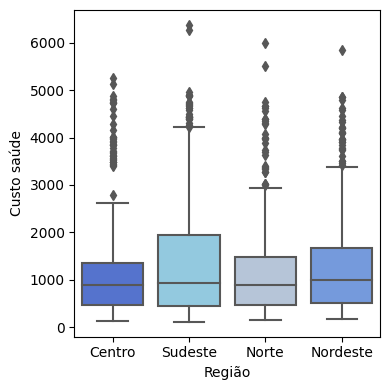

In [38]:
plt.figure(figsize=(4, 4))
#cores = {'Sim': 'red', 'Não': 'blue'}
sns.boxplot(x='Região', y='Custo_Saude', data=df, palette=minha_paleta)
plt.xlabel('Região')
plt.ylabel('Custo saúde')
plt.tight_layout()
plt.show()

In [39]:
variavel_dummie = pd.get_dummies(df['Região'], drop_first=True) #É preciso transformar a variável qualitativa em dummie
variavel_dummie = sm.add_constant(variavel_dummie)
modelo = sm.OLS(df['Custo_Saude'], variavel_dummie).fit() #Cria um modelo de regressão linear simples
r_squared = modelo.rsquared #Extrai o R²
print(f"O coeficiente de determinação (R²) é: {r_squared}")

O coeficiente de determinação (R²) é: 0.00663401680703124


####Custo_Saude X Qte_Filhos

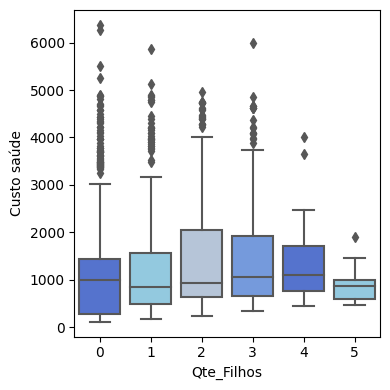

In [40]:
plt.figure(figsize=(4, 4))

sns.boxplot(x='Qte_Filhos', y='Custo_Saude', data=df, palette=minha_paleta)
plt.xlabel('Qte_Filhos')
plt.ylabel('Custo saúde')
plt.tight_layout()
plt.show()

In [41]:
variavel_dummie = pd.get_dummies(df['Qte_Filhos'], drop_first=True) #É preciso transformar a variável qualitativa em dummie
variavel_dummie = sm.add_constant(variavel_dummie)
modelo = sm.OLS(df['Custo_Saude'], variavel_dummie).fit() #Cria um modelo de regressão linear simples
r_squared = modelo.rsquared #Extrai o R²
print(f"O coeficiente de determinação (R²) é: {r_squared}")

O coeficiente de determinação (R²) é: 0.012224537694691562


####Custo_Saude X Idade

<ipython-input-42-185cab848960>:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=df, x='Idade', y='Custo_Saude', palette=minha_paleta)


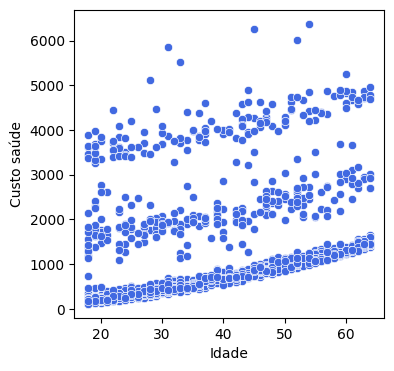

In [42]:
plt.figure(figsize=(4, 4))
sns.scatterplot(data=df, x='Idade', y='Custo_Saude', palette=minha_paleta)
plt.xlabel('Idade')
plt.ylabel('Custo saúde')
plt.show()

In [43]:
correlacao = df['Custo_Saude'].corr(df['Idade'])
print(f"Correlação de Pearson entre Variavel1 e Variavel2: {correlacao}")

Correlação de Pearson entre Variavel1 e Variavel2: 0.2990081933306475


####Custo_Saude X IMC

<ipython-input-44-e272276d6c2d>:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=df, x='IMC', y='Custo_Saude', palette=minha_paleta)


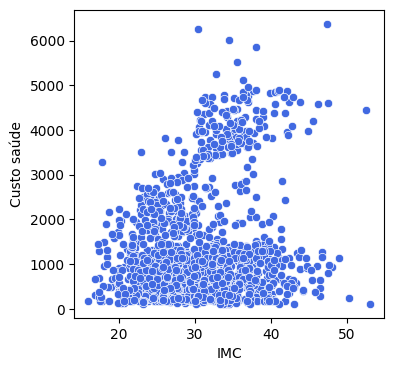

In [44]:
plt.figure(figsize=(4, 4))
sns.scatterplot(data=df, x='IMC', y='Custo_Saude', palette=minha_paleta)
plt.xlabel('IMC')
plt.ylabel('Custo saúde')
plt.show()

In [45]:
correlacao = df['Custo_Saude'].corr(df['IMC'])
print(f"Correlação de Pearson entre Variavel1 e Variavel2: {correlacao}")

Correlação de Pearson entre Variavel1 e Variavel2: 0.19834096883362898


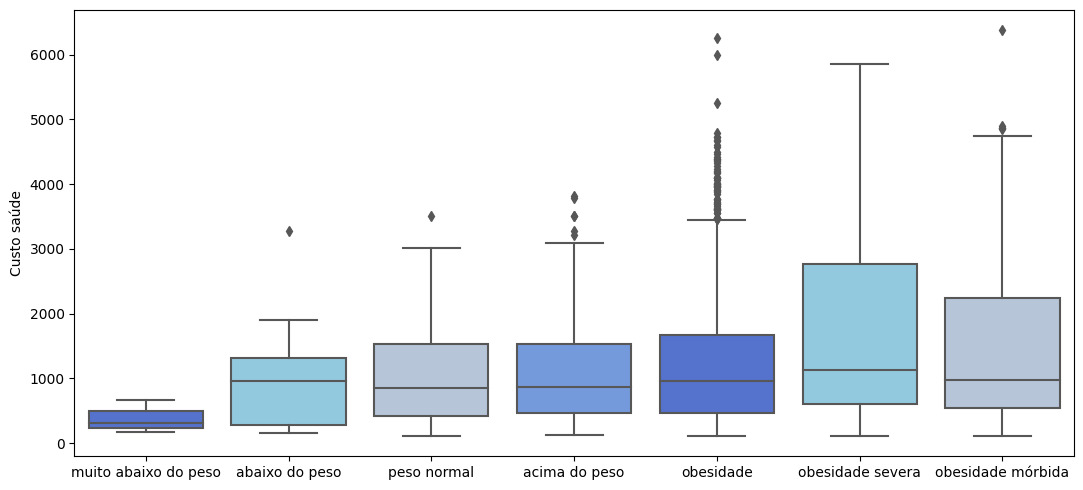

In [213]:
plt.figure(figsize=(11, 5))

sns.boxplot(x='Faixas_IMC', y='Custo_Saude', data=df.sort_values(by='IMC'), palette=minha_paleta)
plt.xlabel('')
plt.ylabel('Custo saúde')
plt.tight_layout()
plt.show()

In [47]:
variavel_dummie = pd.get_dummies(df['Faixas_IMC'], drop_first=True)
variavel_dummie = sm.add_constant(variavel_dummie)
modelo = sm.OLS(df['Custo_Saude'], variavel_dummie).fit()
r_squared = modelo.rsquared #Extrai o R²
print(f"O coeficiente de determinação (R²) é: {r_squared}")

O coeficiente de determinação (R²) é: 0.04661601455637987


####Variáveis com pouca informação

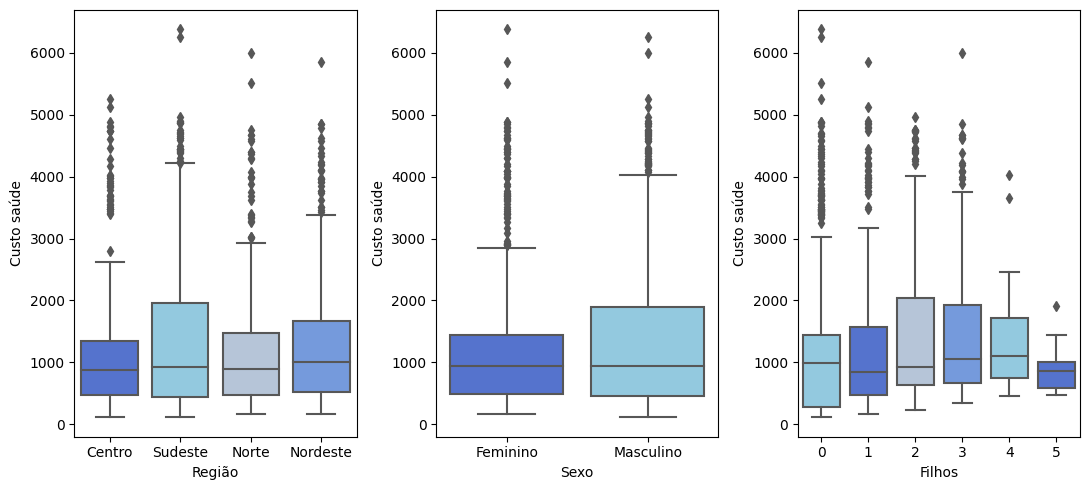

In [48]:
#Plotando o histograma e o boxplot
fig, axes = plt.subplots(1, 3, figsize=(11, 5))

sns.boxplot(x='Região', y='Custo_Saude', data=df, palette={'Sudeste': 'skyblue', 'Centro': 'royalblue',
                                                           'Norte': 'lightsteelblue', 'Nordeste': 'cornflowerblue'}, ax=axes[0])
axes[0].set_xlabel('Região')
axes[0].set_ylabel('Custo saúde')

sns.boxplot(x='Sexo', y='Custo_Saude', data=df, palette={'Masculino': 'skyblue', 'Feminino': 'royalblue'}, ax=axes[1])
axes[1].set_xlabel('Sexo')
axes[1].set_ylabel('Custo saúde')

sns.boxplot(x='Qte_Filhos', y='Custo_Saude', data=df, palette={0: 'skyblue', 1: 'royalblue',
                                                           2: 'lightsteelblue', 3: 'cornflowerblue',
                                                               4: 'skyblue', 5: 'royalblue'}, ax=axes[2])
axes[2].set_xlabel('Filhos')
axes[2].set_ylabel('Custo saúde')

plt.tight_layout()
plt.show()

#Preparação dos dados

##Seleção de variáveis/técnica

In [ ]:
#Tabela ranking de associação
tabela = pd.DataFrame({'Variavel': ['Idade','Sexo','IMC','Qte_Filhos','Fumante','Região'],
                      'Resultado': [0.29,0.003,0.19,0.01,0.61,0.006],
                       'Coeficiente': ['Person','R²','Person','R²','R²','R²']})
tabela['Resultado'] = tabela['Resultado'].round(2)
tabela = tabela.sort_values(by='Resultado', ascending=False)
tabela.reset_index(drop=True, inplace=True)
tabela

,Variavel,Resultado,Coeficiente
0,Fumante,0.61,R²
1,Idade,0.29,Person
2,IMC,0.19,Person
3,Qte_Filhos,0.01,R²
4,Região,0.01,R²
5,Sexo,0.00,R²


##Limpeza e formatação

In [ ]:
df_modelo = df.copy()

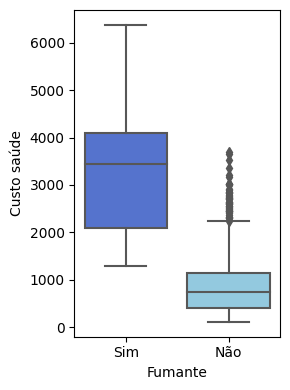

In [ ]:
#R² da variável Fumante = 0.61
plt.figure(figsize=(3, 4))
sns.boxplot(x='Fumante', y='Custo_Saude', data=df_modelo, palette=minha_paleta)
plt.xlabel('Fumante')
plt.ylabel('Custo saúde')
plt.tight_layout()
plt.show()

In [ ]:
#Retirando outliers
df_modelo = df_modelo[~((df_modelo['Custo_Saude']>=2100)&(df_modelo['Fumante']=='Não'))]
df_modelo.reset_index(drop=True, inplace=True)

In [ ]:
#Verificando correlação após retirada de outliers
variavel_dummie = pd.get_dummies(df_modelo['Fumante'], drop_first=True) #É preciso transformar a variável qualitativa em dummie
variavel_dummie = sm.add_constant(variavel_dummie)
modelo = sm.OLS(df_modelo['Custo_Saude'], variavel_dummie).fit() #Cria um modelo de regressão linear simples
r_squared = modelo.rsquared #Extrai o R²
print(f"O coeficiente de determinação (R²) é: {r_squared}")

O coeficiente de determinação (R²) é: 0.7016540101698236


<ipython-input-109-d70412b46cc9>:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=df_modelo, x='IMC', y='Custo_Saude', palette=minha_paleta)


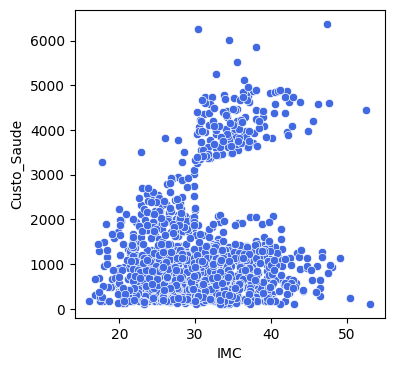

In [ ]:
#Correlação da variável IMC = 0.19
plt.figure(figsize=(4, 4))
sns.scatterplot(data=df_modelo, x='IMC', y='Custo_Saude', palette=minha_paleta)
plt.xlabel('IMC')
plt.ylabel('Custo_Saude')
plt.show()

In [ ]:
#Retirando outliers na dispersão
df_modelo = df_modelo[~(df_modelo['IMC']>=50)]
df_modelo = df_modelo[~((df_modelo['Custo_Saude']>=3000)&(df_modelo['IMC']<=25))]
df_modelo = df_modelo[~(df_modelo['Custo_Saude']>=6000)]
df_modelo = df_modelo[~((df_modelo['Custo_Saude']>=5100)&(df_modelo['IMC']<=40))]
df_modelo.reset_index(drop=True, inplace=True)

In [ ]:
#Verificando correlação após retirada de outliers
correlacao = df_modelo['Custo_Saude'].corr(df_modelo['IMC'])
print(f"Correlação de Pearson entre Custo e Idade: {correlacao}")

Correlação de Pearson entre Custo e Idade: 0.20251907090518081


<ipython-input-112-58285579533e>:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=df_modelo, x='Idade', y='Custo_Saude', palette=minha_paleta)


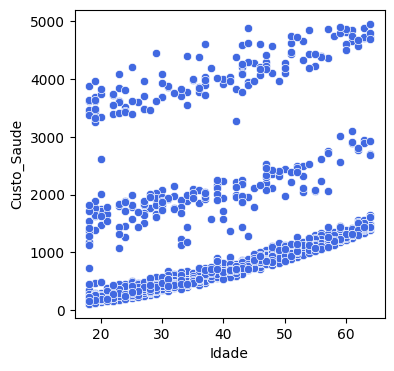

In [ ]:
#Correlação da variável Idade = 0.29
plt.figure(figsize=(4, 4))
sns.scatterplot(data=df_modelo, x='Idade', y='Custo_Saude', palette=minha_paleta)
plt.xlabel('Idade')
plt.ylabel('Custo_Saude')
plt.show()

In [ ]:
#Retirando outliers
df_modelo = df_modelo[~((df_modelo['Idade']==20)&(df_modelo['Custo_Saude']>2500)&(df_modelo['Custo_Saude']<3000))]
df_modelo = df_modelo[~((df_modelo['Idade']>=42)&(df_modelo['Custo_Saude']==3278.745859))]

In [ ]:
#Verificando correlação após retirada de outliers
correlacao = df_modelo['Custo_Saude'].corr(df_modelo['Idade'])
print(f"Correlação de Pearson entre Custo e Idade: {correlacao}")

Correlação de Pearson entre Custo e Idade: 0.29869639693151506


In [ ]:
#Verificando a multicolineariedade entre as variáveis quantitativas
multicolineariedade = df_modelo[['IMC','Idade']].corr()
multicolineariedade

,IMC,Idade
IMC,1.000000,0.116688
Idade,0.116688,1.000000


In [ ]:
df_modelo = pd.get_dummies(df_modelo, drop_first=True)

# Variável resposta
y = df_modelo['Custo_Saude']

# Variáveis explicativas
df_modelo['intercepto'] = 1
x = df_modelo[['intercepto',
         'Fumante_Sim',
               'Idade',
               'IMC',
               'Qte_Filhos',]]

#Modelagem

In [ ]:
#Treinando o modelo
modelo = sm.OLS(y , x)
resultado = modelo.fit()

print(resultado.summary())

                            OLS Regression Results                            
Dep. Variable:            Custo_Saude   R-squared:                       0.832
Model:                            OLS   Adj. R-squared:                  0.831
Method:                 Least Squares   F-statistic:                     1563.
Date:                Mon, 02 Oct 2023   Prob (F-statistic):               0.00
Time:                        10:34:41   Log-Likelihood:                -9629.5
No. Observations:                1271   AIC:                         1.927e+04
Df Residuals:                    1266   BIC:                         1.929e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
intercepto  -1244.7460     75.748    -16.433      

O custo aumenta em média R2400 reais caso o usuário seja fumante, R24 em média a cada ano de vida e R32 em média a cada ponto no IMC

In [ ]:
#Fazendo a previsão no df geral e calculando o erro quadrático
df_geral = df.copy()
df_geral['Fumante_Sim'] = 0
for cont in range(0,len(df_geral)):
  if df_geral['Fumante'][cont] == 'Sim':
    df_geral['Fumante_Sim'][cont] = 1

intercepto = -1244.7460
Fumante_Sim = 2397.7798
Idade = 23.9928
IMC = 32.9433
Qte_Filhos = 42.6255

df_geral['custo_estimado'] = intercepto + IMC * df_geral['IMC'] + Idade * df_geral['Idade'] + Fumante_Sim * \
df_geral['Fumante_Sim'] + Qte_Filhos * df_geral['Qte_Filhos']

df_geral['erroquadrado_estimativa'] = (df_geral['Custo_Saude']-df_geral['custo_estimado'])**2
soma_erros = df_geral['erroquadrado_estimativa'].sum()
soma_erros

<ipython-input-123-7228346ab921>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_geral['Fumante_Sim'][cont] = 1


501030178.86083126

Com a variável 'Qte_Filhos' o erro ficou em 501030178.86083126, sem ela ficou em 505356163.49039817

Analisando os resíduos

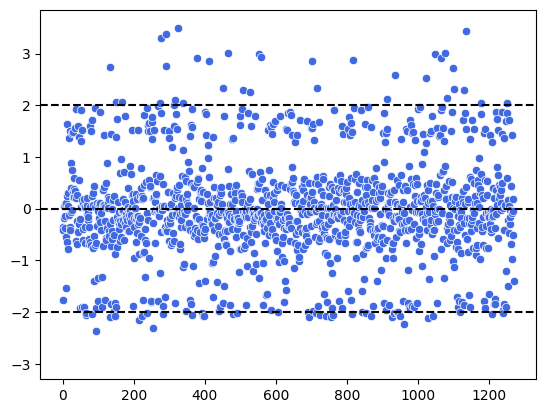

In [ ]:
def grafico_residuos(resultado):
    resid_graf = sns.scatterplot(x=list(range(0,len(resultado.resid_pearson))),
                                 y=resultado.resid_pearson.tolist())

    # Localizando valor mínimo dos resíduos
    r_aux = resultado.resid_pearson.tolist()
    r_aux.append(-3)
    ymin = min(r_aux) * 1.1

    # Localizando valor máximo dos resíduos
    r_aux = resultado.resid_pearson.tolist()
    r_aux.append(+3)
    ymax = max(r_aux) * 1.1

    resid_graf.set(ylim=(ymin, ymax))

    ax1 = resid_graf.axes
    ax1.axhline( 0, color='black', ls='--')
    ax1.axhline(-2, color='black', ls='--')
    ax1.axhline(+2, color='black', ls='--')
    plt.show()

grafico_residuos(resultado)

In [ ]:
#Teste de hipótese
#H0 = resíduos homocedásticos
from statsmodels.stats.diagnostic import het_white
labels = ['LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value']

white_test = het_white(resultado.resid_pearson,
                       resultado.model.exog)

print(dict(zip(labels, white_test)))

{'LM Statistic': 25.42876049945445, 'LM-Test p-value': 0.0078858525981758, 'F-Statistic': 2.3363514576625053, 'F-Test p-value': 0.0076098882355698965}


<ipython-input-121-dfc3a51ed4d4>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(resultado.resid_pearson)


<Axes: ylabel='Density'>

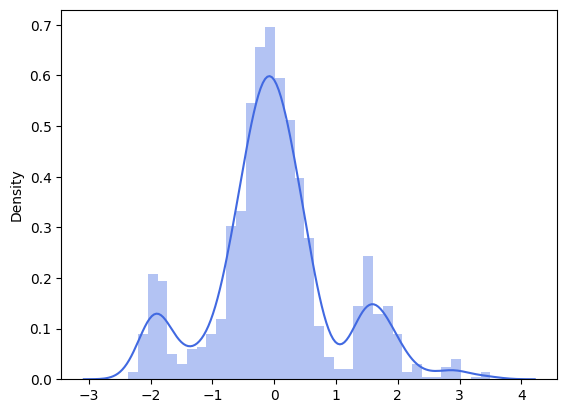

In [ ]:
sns.distplot(resultado.resid_pearson)

In [ ]:
#Teste de hipótese
#H0 = distribuição normal
from scipy.stats import shapiro
normalidade = shapiro(resultado.resid_pearson)
print('Estatística=%.3f, p-valor=%.3f\n' % (normalidade.statistic, normalidade.pvalue))

Estatística=0.553, p-valor=0.000



#Conclusão

##Análise dos grupos

In [49]:
#Dividindo os grupos
df_grupo = df.copy()
df_grupo['Grupo'] = ''
for indice in range(0,len(df_grupo)):
  if df_grupo['Fumante'][indice] == 'Não':
    df_grupo['Grupo'][indice] = 'Não fumante'
  elif df_grupo['Fumante'][indice] == 'Sim' and df_grupo['IMC'][indice] <= 29.99:
    df_grupo['Grupo'][indice] = 'Fumante'
  else:
    df_grupo['Grupo'][indice] = 'Fumante e obeso'

<ipython-input-49-b2a775475ca8>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_grupo['Grupo'][indice] = 'Fumante'
<ipython-input-49-b2a775475ca8>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_grupo['Grupo'][indice] = 'Não fumante'
<ipython-input-49-b2a775475ca8>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_grupo['Grupo'][indice] = 'Fumante e obeso'


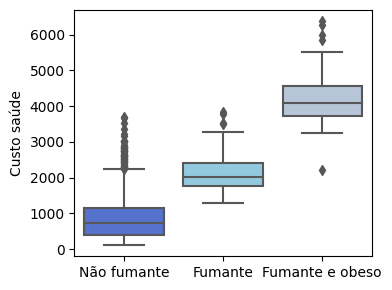

In [50]:
plt.figure(figsize=(4, 3))

sns.boxplot(x='Grupo', y='Custo_Saude', data=df_grupo.sort_values(by='Custo_Saude'), palette=minha_paleta)
plt.xlabel('')
plt.ylabel('Custo saúde')
plt.tight_layout()
plt.show()

In [51]:
#Proproção do custo total referente ao grupo 1
df_grupo[df_grupo['Grupo']=='Não fumante']['Custo_Saude'].sum()/df_grupo['Custo_Saude'].sum()

0.5054150665254665

In [52]:
#Medidas resumo do grupo 1
df_grupo[df_grupo['Grupo']=='Não fumante']['Custo_Saude'].describe()

count    1064.000000
mean      843.426830
std       599.378182
min       112.187390
25%       398.643870
50%       734.540530
75%      1136.288705
max      3691.060803
Name: Custo_Saude, dtype: float64

In [53]:
#Proproção do custo total referente ao grupo 1
df_grupo[df_grupo['Grupo']=='Fumante']['Custo_Saude'].sum()/df_grupo['Custo_Saude'].sum()

0.1552085018011994

In [54]:
#Medidas resumo do grupo 2
df_grupo[df_grupo['Grupo']=='Fumante']['Custo_Saude'].describe()

count     129.000000
mean     2136.321702
std       506.678052
min      1282.945510
25%      1766.314420
50%      2016.733603
75%      2410.691255
max      3824.559327
Name: Custo_Saude, dtype: float64

In [55]:
#Proproção do custo total referente ao grupo 1
df_grupo[df_grupo['Grupo']=='Fumante e obeso']['Custo_Saude'].sum()/df_grupo['Custo_Saude'].sum()

0.33937643167333414

In [56]:
df_grupo[df_grupo['Grupo']=='Fumante e obeso']['Custo_Saude'].describe()

count     145.000000
mean     4155.798984
std       603.147368
min      2214.403200
25%      3716.516380
50%      4090.419950
75%      4570.202235
max      6377.042801
Name: Custo_Saude, dtype: float64

In [57]:
tabela = tabela_frequencia(df_grupo['Grupo'])
tabela['Custo_Saude'] = [897406.14,602590.85, 275585.49]
tabela

,Grupo,frequencia_absoluta,frequencia_relativa,frequencia_acumulada,Custo_Saude
0,Não fumante,1064,0.795217,0.795217,897406.14
1,Fumante e obeso,145,0.108371,0.903587,602590.85
2,Fumante,129,0.096413,1.000000,275585.49


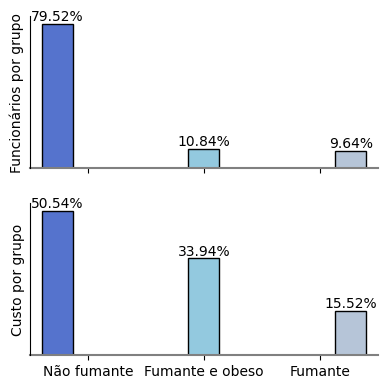

In [58]:
# Plotando o gráfico de barras por grupos
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(4, 4), sharex=True)

x = tabela['Grupo']
y1 = tabela['frequencia_relativa']*100
sns.barplot(x=x, y=y1, hue=x ,ax=ax1, edgecolor='black')
ax1.axhline(0, color='gray', clip_on=False)
ax1.set_ylabel("Funcionários por grupo")
ax1.set_xlabel("")
ax1.legend().set_visible(False)

y2 = (tabela['Custo_Saude']/tabela['Custo_Saude'].sum())*100
sns.barplot(x=x, y=y2, hue=x, ax=ax2, edgecolor='black')
ax2.axhline(0, color='gray', clip_on=False)
ax2.set_ylabel("Custo por grupo")
ax2.set_xlabel("")
ax2.legend().set_visible(False)

for p in ax1.patches:
    ax1.annotate(f'{p.get_height():.2f}%', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 5), textcoords='offset points')
for p in ax2.patches:
    ax2.annotate(f'{p.get_height():.2f}%', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 5), textcoords='offset points')

sns.despine(bottom=True)
plt.setp(f.axes, yticks=[])
plt.tight_layout(h_pad=2)

##Teste

In [188]:
#Separando grupo "fumante e obeso" em teste e controle
df_teste = df_grupo[df_grupo['Grupo']== 'Fumante e obeso']
X_controle, X_teste = train_test_split(df_teste, test_size=0.5, random_state=42)
X_controle = X_controle.reset_index(drop=True)
X_teste = X_teste.reset_index(drop=True)

In [ ]:
#reduzindo para 26,8% obesos
X_teste['IMC_Perdido'] = 0
random.seed(1)
while True:
    indice = random.randint(0, 73)
    X_teste['IMC_Perdido'][indice] = X_teste['IMC'][indice] - 24.99
    X_teste['IMC'][indice] = 29.99
    percentual = len(X_teste[X_teste['IMC'] >= 30]) / len(X_teste)

    if percentual <= 0.268:
        break


In [196]:
#reduzindo 12,6% fumantes
X_teste['Parou_fumar'] = 0
random.seed(2)
while True:
    indice = random.randint(0, 73)
    X_teste['Parou_fumar'][indice] = 2397.7798
    percentual = len(X_teste[X_teste['Parou_fumar'] == 0]) / len(X_teste)

    if percentual <= 0.126:
        break

0.1232876712328767

In [191]:
#prevendo o custo
#subtraindo o coeficiente 'Fumante_Sim'
X_teste['custo_estimado'] = 0
X_teste['custo_estimado'] = X_teste['Custo_Saude'] - X_teste['Parou_fumar'] - X_teste['IMC_Perdido'] * 32.9433

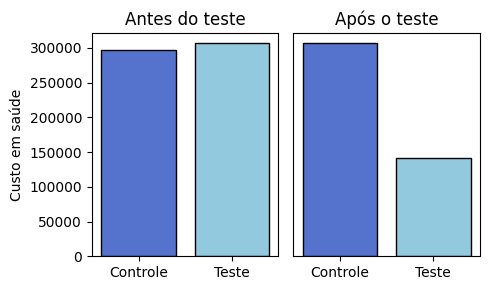

In [208]:
#Plotando a diferença na redução do custo
barras1 = ['Controle', 'Teste']
alturas1 = [X_controle['Custo_Saude'].sum(), X_teste['Custo_Saude'].sum()]
barras2 = ['Controle', 'Teste']
alturas2 = [X_controle['Custo_Saude'].sum(), X_teste['custo_estimado'].sum()]

fig, ax = plt.subplots(1, 2, figsize=(5, 3))


sns.barplot(x=barras1, y=alturas1, ax=ax[0], edgecolor='black')
ax[0].set_ylabel('Custo em saúde')
ax[0].set_title('Antes do teste')


sns.barplot(x=barras2, y=alturas2, ax=ax[1], edgecolor='black')
ax[1].set_title('Após o teste')
plt.yticks([])


plt.tight_layout()

plt.show()

In [212]:
#Redução no custo
(X_teste['Custo_Saude'].sum() - X_teste['custo_estimado'].sum()) / X_teste['Custo_Saude'].sum()


0.5508309223720191